# Exact Diagonalization (ED)

* Author: Pochung Chen
* Email: pcchen@phys.nthu.edu.tw
* Last updated on 3/16/2022

## Transverse-Field Ising Model (TFIM)

### References:
* Annals of Physics 57, 79 (1970).
* J. Stat. Mech. (2017) P093101.
* Α α, Β β, Γ γ, Δ δ, Ε ε, Ζ ζ, Η η, Θ θ, Ι ι, Κ κ, Λ λ, Μ μ, Ν ν, Ξ ξ, Ο ο, Π π, Ρ ρ, Σ σ/ς, Τ τ, Υ υ, Φ φ, Χ χ, Ψ ψ, and Ω ω.

Consider 1D ferromagnetic (FM) transverse-field Ising model (TFIM) with periodic boundary condition (PBC)

$$
  H = -J \sum_{i=1}^N S^x_i S^x_{i+1} - h \sum_{i=1}^N S^z_i, 
$$
where $\vec{S}=\frac{1}{2}\vec{\sigma}$ and the spin operators and $\sigma$ are the Pauli matrices. $N$ is the number of sites.
We require $J>0$ to ensure the system is ferromagnetic. There is a quantum phase transition at $h/J=1/2$. 

Define
$$
  E_k \equiv \sqrt{ (J/2)^2 + h^2 + Jh\cos(k).
  }
$$

$$
  \Lambda_a \equiv \left\{
    \pm \frac{\pi}{N}, \pm \frac{3\pi}{N}, \cdots, \pm \frac{(N-1)\pi}{N}
  \right\}.
$$

$$
  \Lambda_p \equiv \left\{
    0, \pm \frac{2\pi}{N}, \pm \frac{4\pi}{N}, \cdots, \pm \frac{(N-2)\pi}{N}, \pi
  \right\}.
$$

The ground state energy $E_0$ and first excited state energy $E_1$ are:
$$
  E_0 = -\frac{1}{2}\sum_{k \in \Lambda_a} E_k
$$
$$
  E_1 = - \frac{J}{2} -\frac{1}{2}\sum_{k \in \Lambda_p, k \notin \{0, \pi\}} E_k ,
$$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse.linalg import *
from scipy.sparse import *

In [2]:
row = np.array([0, 1])
col = np.array([1, 0])
data = np.array([1, 1])
σx = csr_matrix((data, (row, col)), shape=(2, 2))
print('σx=')
print(σx.toarray())

row = np.array([0, 1])
col = np.array([1, 0])
data = np.array([-1j, +1j])
σy = csr_matrix((data, (row, col)), shape=(2, 2))
print('σy=')
print(σy.toarray())

row = np.array([0, 1])
col = np.array([0, 1])
data = np.array([+1, -1])
σz = csr_matrix((data, (row, col)), shape=(2, 2))
print('σz=')
print(σz.toarray())

Sx = σx/2
Sy = σy/2
Sz = σz/2


Id = eye(2)
print('Id=')
print(Id.toarray())

σx=
[[0 1]
 [1 0]]
σy=
[[0.+0.j 0.-1.j]
 [0.+1.j 0.+0.j]]
σz=
[[ 1  0]
 [ 0 -1]]
Id=
[[1. 0.]
 [0. 1.]]


In [3]:
print(kron(Sz, Sz).toarray())

[[ 0.25  0.    0.    0.  ]
 [ 0.   -0.25  0.    0.  ]
 [ 0.    0.   -0.25  0.  ]
 [ 0.    0.    0.    0.25]]


In [4]:
J = 1
def H_X(N):
    H_X = csr_matrix((2**N, 2**N))

    for i in range(N):
        if i == 0 :
            HL = Sx
        else:
            HL = Id
        for j in range(1, N):
            if j == i:
                HL = kron(HL, Sx, format='csr')
            else:
                HL = kron(HL, Id, format='csr')
        H_X = H_X + HL
    return H_X

def H_Z(N):
    H_Z = csr_matrix((2**N, 2**N))

    for i in range(N):
        if i == 0 :
            HL = Sz
        else:
            HL = Id
        for j in range(1, N):
            if j == i:
                HL = kron(HL, Sz, format='csr')
            else:
                HL = kron(HL, Id, format='csr')
        H_Z = H_Z + HL
    return H_Z

def H_XX(N):
    H_XX = csr_matrix((2**N, 2**N))

    # OBC
    for i in range(N-1):
        if i == 0 :
            HL = Sx
        else:
            HL = Id
        for j in range(1, N):
            if j ==i or j == i+1:
                HL = kron(HL, Sx, format='csr')
            else:
                HL = kron(HL, Id, format='csr')
        H_XX = H_XX + HL

    # PBC end to end term
    HL = Sx
    for i in range(1, N-1):
        HL = kron(HL, Id, format='csr')
    HL = kron(HL, Sx, format='csr')
    H_XX = H_XX + HL
    return H_XX

def H_ZZ(N):
    H_ZZ = csr_matrix((2**N, 2**N))

    # OBC
    for i in range(N-1):
        if i == 0 :
            HL = Sz
        else:
            HL = Id
        for j in range(1, N):
            if j ==i or j == i+1:
                HL = kron(HL, Sz, format='csr')
            else:
                HL = kron(HL, Id, format='csr')
        H_ZZ = H_ZZ + HL

    # PBC end to end term
    HL = Sz
    for i in range(1, N-1):
        HL = kron(HL, Id, format='csr')
    HL = kron(HL, Sz, format='csr')
    H_ZZ = H_ZZ + HL
    return H_ZZ

In [5]:
type(H_X(10))

scipy.sparse.csr.csr_matrix

In [5]:
J = 1
h = 1/2

for N in [4]:
# for N in [4, 6, 8, 10, 12]:
    Ham_XX = -J*H_XX(N)
    print(type(Ham_XX))
    Ham_Z = -h*H_Z(N)
    print(type(Ham_Z))
    H = Ham_XX + Ham_Z
    # H = -J*H_XX(N)-h*H_Z(N)
    print(type(H))
    w, v = eigsh(H, 2, which='SA')
    print('N','E0', 'E1', 'E1-E0')
    print(w)
    print(N, w[0], w[1], w[1]-w[0])
    # print('<E0|H|E0>', '<E0|H_X|E0>', '<E0|H_Z|E0>')
    # print(v[:,0]@H@v[:,0],v[:,0]@H_X(N)@v[:,0]/N,v[:,0]@H_Z(N)@v[:,0]/N)
    # print(v[:,0]@H_Z(N)@v[:,0]) 

<class 'scipy.sparse.csr.csr_matrix'>
<class 'scipy.sparse.csr.csr_matrix'>
<class 'scipy.sparse.csr.csr_matrix'>
N E0 E1 E1-E0
[-1.30656296 -1.20710678]
4 -1.3065629648763761 -1.2071067811865477 0.09945618368982845


In [27]:
J = 1
h = 1
hx = (1j)*0

for N in [4]:
# for N in [4, 6, 8, 10, 12]:
    Ham_XX = -J*H_XX(N)
    # print(type(Ham_XX))
    Ham_Z = -h*H_Z(N)
    # print(type(Ham_Z))
    Ham_X = -hx*H_X(N)
    # print(type(Ham_X))    
    H = Ham_XX + Ham_Z + Ham_X
    # H = -J*H_XX(N)-h*H_Z(N)
    # print(type(H))
    w, v = eigs(H, 10, which='SR')
    print('N','E0', 'E1', 'E1-E0')
    print(w)
    print(N, w[0], w[1], w[1]-w[0])
    # print('<E0|H|E0>', '<E0|H_X|E0>', '<E0|H_Z|E0>')
    # print(v[:,0]@H@v[:,0],v[:,0]@H_X(N)@v[:,0]/N,v[:,0]@H_Z(N)@v[:,0]/N)
    # print(v[:,0]@H_Z(N)@v[:,0]) 

N E0 E1 E1-E0
[-2.13577921e+00-1.16965349e-16j -1.61803399e+00-2.09450548e-17j
 -6.18033989e-01+1.10068718e-17j -6.62153447e-01+5.57607777e-17j
 -7.03816266e-17+8.88907331e-18j -1.00000000e+00-3.03232961e-31j
 -1.00000000e+00-2.90566182e-17j  2.96167636e-17+1.51218189e-17j
  3.24642096e-33-1.82167911e-33j -4.50891130e-33+7.54432247e-33j]
4 (-2.135779205069861-1.1696534874170082e-16j) (-1.6180339887498978-2.0945054769083283e-17j) (0.5177452163199632+9.602029397261754e-17j)


In [8]:
J = 2
hz = 1
hx = 0.1

for N in [8]:
# for N in [4, 6, 8, 10]:
    # H = -J*H_XX(N)-hz*H_Z(N)-(1j)*hx*H_X(N)
    # w = np.linalg.eigvals(H)
    # print('N','E0', 'E1', 'E1-E0')
    # print('N={}'.format(N))
    # w = np.sort_complex(w)
    # print(np.real(w[:4]))
    # print(np.imag(w[:4]))
    
    H = -J*H_XX(N)-hz*H_Z(N)-(1j)*hx*H_X(N)
    w, _ = eigs(H,which='SR')
    print('N','E0', 'E1', 'E1-E0')
    print('N={}'.format(N))
    w = np.sort_complex(w)
    print(np.real(w[:4]))
    print(np.imag(w[:4]))    

N E0 E1 E1-E0
N=8
[-5.06039212 -5.06039212 -4.34097616 -4.2319902 ]
[ 3.10407230e-01 -3.10407230e-01  9.26386226e-16 -6.10622664e-16]


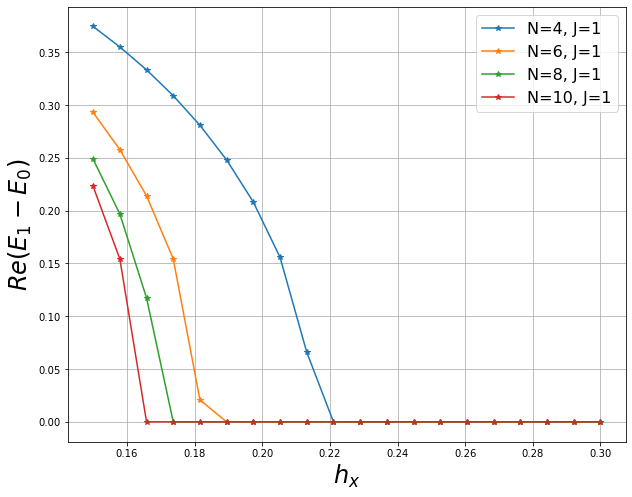

In [9]:
fig, ax = plt.subplots(figsize=(10,8))

hz = 1
for N in [4,6,8,10]:
    # print(N,)
    hx = np.linspace(0.15, 0.3, 20)
    for J in [1]:
        E0 = np.zeros_like(hx,dtype=complex)
        E1 = np.zeros_like(hx,dtype=complex)     
        for i in range(hx.shape[0]):
            # print(i)
            H = -J*H_XX(N)-hz*H_Z(N)-(1j)*hx[i]*H_X(N)
            # w = np.linalg.eigvals(H)
            w, _ = eigs(H,which='SR')            
            # print(w)
            w = np.sort_complex(w)
            E0[i] = w[0]
            E1[i] = w[1]
        ax.plot(hx, np.real(E1-E0),'*-',label='N={}, J={}'.format(N, J))

ax.set_xlabel(r'$h_x$', fontsize=24)
ax.set_ylabel(r'$Re(E_1-E_0)}$', fontsize=24)
# ax.set_ylim([0,10])
# ax.semilogy()
ax.legend(fontsize=16)
ax.grid()

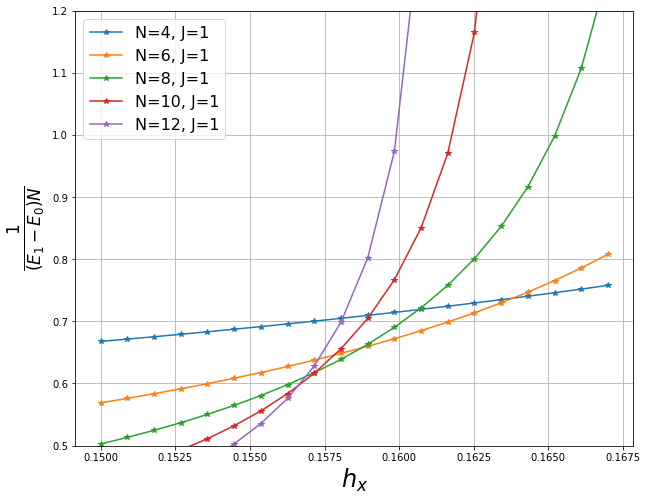

In [11]:
fig, ax = plt.subplots(figsize=(10,8))

hz = 1
for N in [4,6,8,10,12]:
    hx = np.linspace(0.15, 0.167 ,20)
    for J in [1]:
        E0 = np.zeros_like(hx,dtype=complex)
        E1 = np.zeros_like(hx,dtype=complex)     

        for i in range(hx.shape[0]):
            H = -J*H_XX(N)-hz*H_Z(N)-(1j)*hx[i]*H_X(N)
            # w = np.linalg.eigvals(H)
            w, _ = eigs(H,which='SR') 
            # print(w)
            w = np.sort_complex(w)
            E0[i] = w[0]
            E1[i] = w[1]
        ax.plot(hx, 1/((np.real(E1-E0)*N)),'*-',label='N={}, J={}'.format(N, J))

ax.set_xlabel(r'$h_x$', fontsize=24)
ax.set_ylabel(r'$\frac{1}{(E_1-E_0)N}$', fontsize=24)
ax.set_ylim([0.5,1.2])
# ax.semilogy()
ax.legend(fontsize=16)
ax.grid()

4
6
8
10


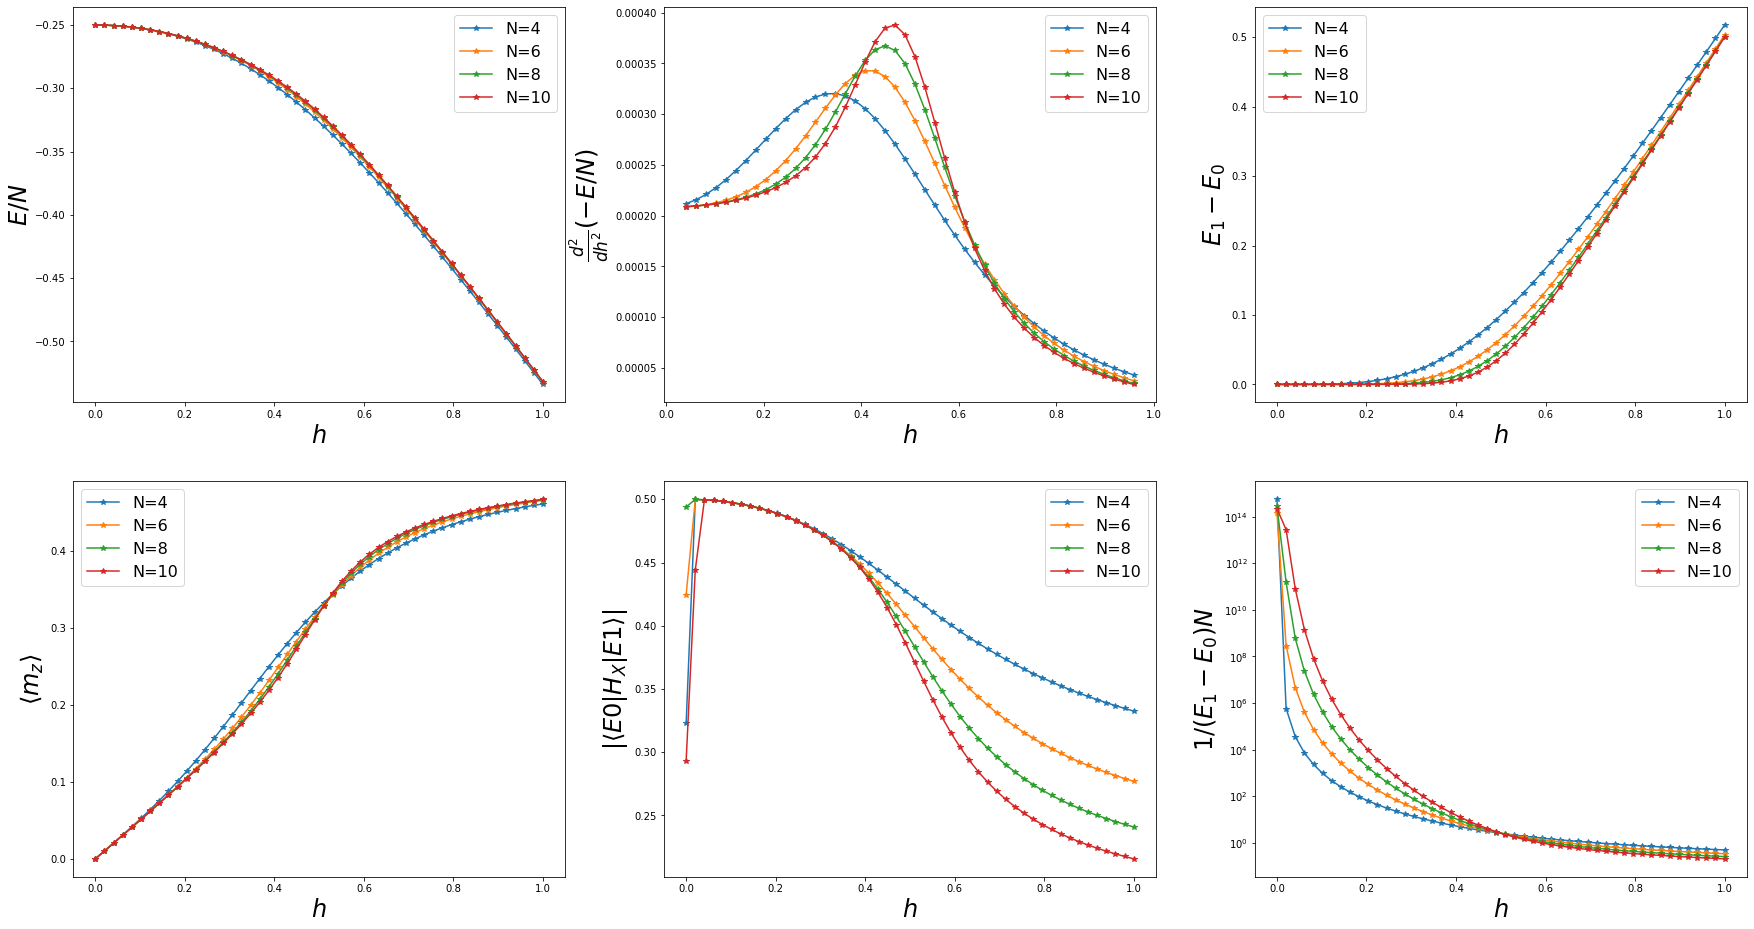

In [14]:
fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(10*3,8*2))
ax = ax.flatten()

for N in [4,6,8,10]:
    print(N)
    h = np.linspace(0,1)
    E0 = np.zeros_like(h)
    E1 = np.zeros_like(h)      
    mx = np.zeros_like(h)
    mz = np.zeros_like(h)

    for i in range(h.shape[0]):
        H = -J*H_XX(N)-h[i]*H_Z(N)
        # w, v = np.linalg.eigh(H)
        w, v = eigsh(H, 2, which='SA')
        # print(v.shape)
        E0[i] = w[0]
        E1[i] = w[1]
        mx[i] = v[:,1]@H_X(N)@v[:,0]/N
        mz[i] = v[:,0]@H_Z(N)@v[:,0]/N

    # E
    ax[0].plot(h, E0/N, '*-',label='N={}'.format(N))
    ax[0].legend(fontsize=16)
    ax[0].set_xlabel(r'$h$',fontsize=24)
    ax[0].set_ylabel(r'$E/N$',fontsize=24)
    ax[0].grid()
    
    # d^2E/Eh^2
    ax[1].plot(h[2:-2], np.gradient(np.gradient(-E0/N))[2:-2], '*-', label='N={}'.format(N))
    ax[1].legend(fontsize=16)
    ax[1].set_xlabel(r'$h$',fontsize=24)
    ax[1].set_ylabel(r'$\frac{d^2}{dh^2}(-E/N)$',fontsize=24)
    ax[1].grid()    

    # xi/L
    ax[5].plot(h, 1/((E1-E0)*N), '*-', label='N={}'.format(N))
    ax[5].legend(fontsize=16)
    ax[5].set_xlabel(r'$h$',fontsize=24)
    ax[5].set_ylabel(r'$1/(E_1-E_0)N$',fontsize=24)
    ax[5].semilogy()
    ax[5].grid()    
    
    # gap
    ax[2].plot(h, E1-E0, '*-',label='N={}'.format(N))
    ax[2].legend(fontsize=16)
    ax[2].set_xlabel(r'$h$',fontsize=24)
    ax[2].set_ylabel(r'$E_1-E_0$',fontsize=24)
    ax[2].grid()

    # mz
    ax[3].plot(h, mz, '*-',label='N={}'.format(N))
    ax[3].legend(fontsize=16)
    ax[3].set_xlabel(r'$h$',fontsize=24)
    ax[3].set_ylabel(r'$\langle m_z \rangle$',fontsize=24)
    ax[3].grid()   
    
    # mx
    ax[4].plot(h, np.abs(mx), '*-',label='N={}'.format(N))
    ax[4].legend(fontsize=16)
    ax[4].set_xlabel(r'$h$',fontsize=24)
    ax[4].set_ylabel(r'$| \langle E0|H_X|E1 \rangle |$',fontsize=24)
    ax[4].grid()    

4
6
8


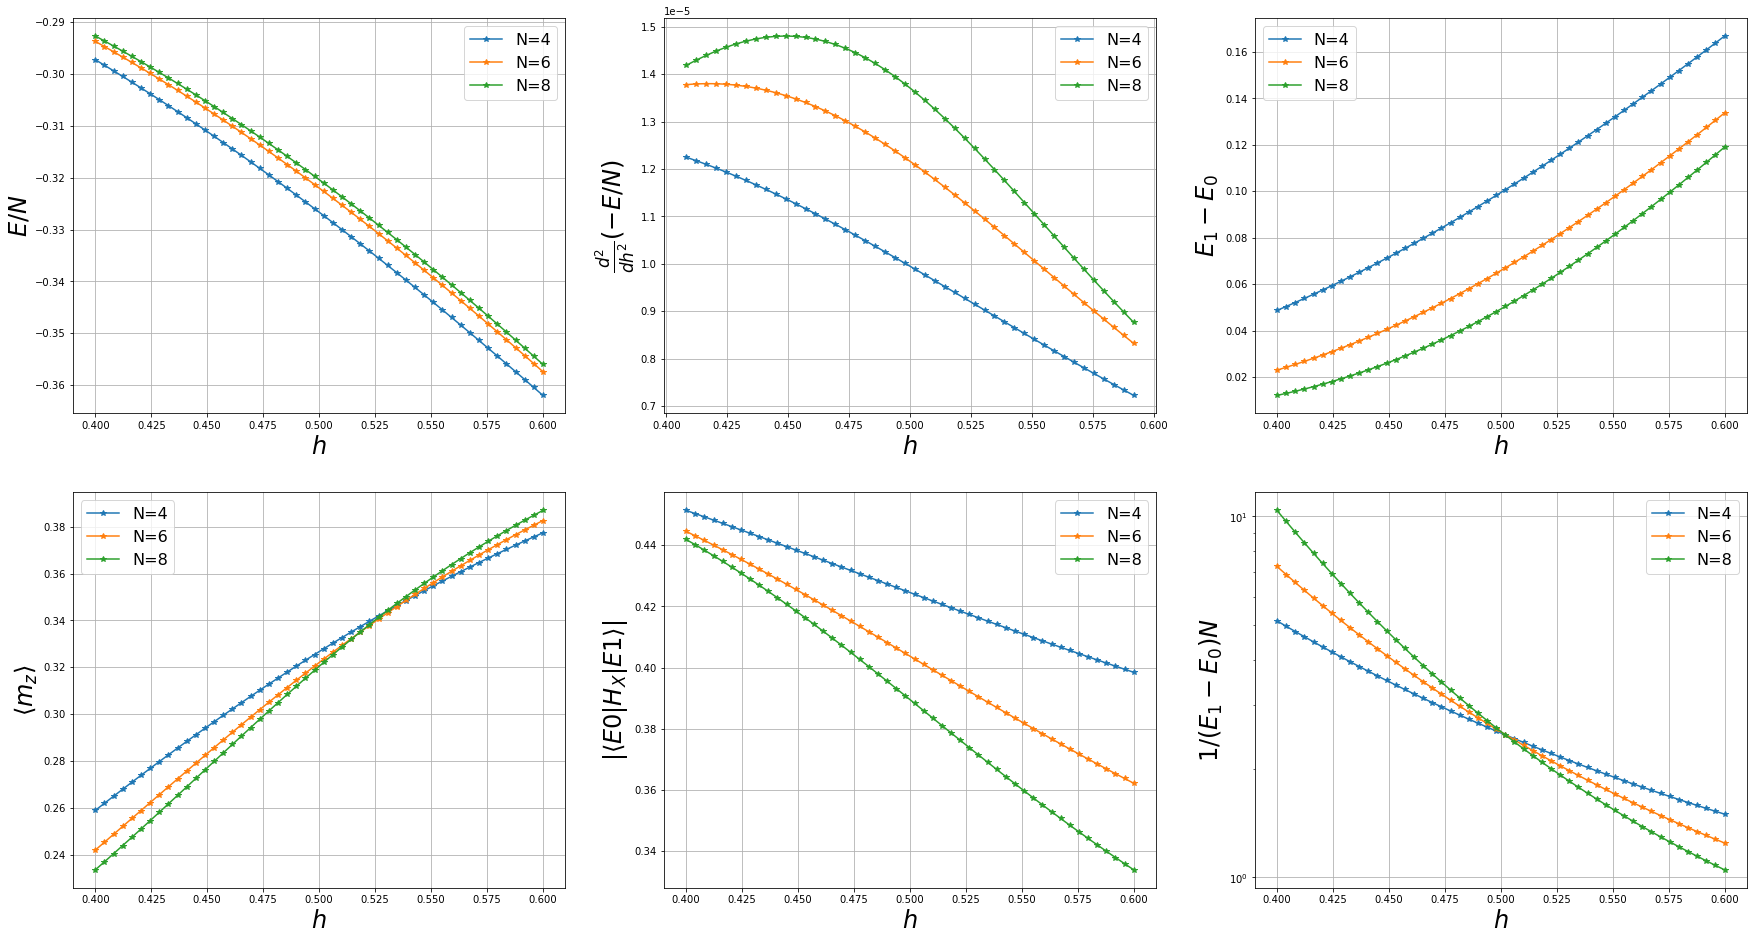

In [6]:
fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(10*3,8*2))
ax = ax.flatten()

for N in [4,6,8]:
    print(N)
    h = np.linspace(0.4,0.6)
    E0 = np.zeros_like(h)
    E1 = np.zeros_like(h)      
    mx = np.zeros_like(h)
    mz = np.zeros_like(h)

    for i in range(h.shape[0]):
        H = -J*H_XX(N)-h[i]*H_Z(N)
        # w, v = np.linalg.eigh(H)
        w, v = eigsh(H, 2, which='SA')
        # print(v.shape)
        E0[i] = w[0]
        E1[i] = w[1]
        mx[i] = v[:,1]@H_X(N)@v[:,0]/N
        mz[i] = v[:,0]@H_Z(N)@v[:,0]/N

    # E
    ax[0].plot(h, E0/N, '*-',label='N={}'.format(N))
    ax[0].legend(fontsize=16)
    ax[0].set_xlabel(r'$h$',fontsize=24)
    ax[0].set_ylabel(r'$E/N$',fontsize=24)
    ax[0].grid()
    
    # d^2E/Eh^2
    ax[1].plot(h[2:-2], np.gradient(np.gradient(-E0/N))[2:-2], '*-', label='N={}'.format(N))
    ax[1].legend(fontsize=16)
    ax[1].set_xlabel(r'$h$',fontsize=24)
    ax[1].set_ylabel(r'$\frac{d^2}{dh^2}(-E/N)$',fontsize=24)
    ax[1].grid()    

    # xi/L
    ax[5].plot(h, 1/((E1-E0)*N), '*-', label='N={}'.format(N))
    ax[5].legend(fontsize=16)
    ax[5].set_xlabel(r'$h$',fontsize=24)
    ax[5].set_ylabel(r'$1/(E_1-E_0)N$',fontsize=24)
    ax[5].semilogy()
    ax[5].grid()    
    
    # gap
    ax[2].plot(h, E1-E0, '*-',label='N={}'.format(N))
    ax[2].legend(fontsize=16)
    ax[2].set_xlabel(r'$h$',fontsize=24)
    ax[2].set_ylabel(r'$E_1-E_0$',fontsize=24)
    ax[2].grid()

    # mz
    ax[3].plot(h, mz, '*-',label='N={}'.format(N))
    ax[3].legend(fontsize=16)
    ax[3].set_xlabel(r'$h$',fontsize=24)
    ax[3].set_ylabel(r'$\langle m_z \rangle$',fontsize=24)
    ax[3].grid()   
    
    # mx
    ax[4].plot(h, np.abs(mx), '*-',label='N={}'.format(N))
    ax[4].legend(fontsize=16)
    ax[4].set_xlabel(r'$h$',fontsize=24)
    ax[4].set_ylabel(r'$| \langle E0|H_X|E1 \rangle |$',fontsize=24)
    ax[4].grid()    

4
6
8
10


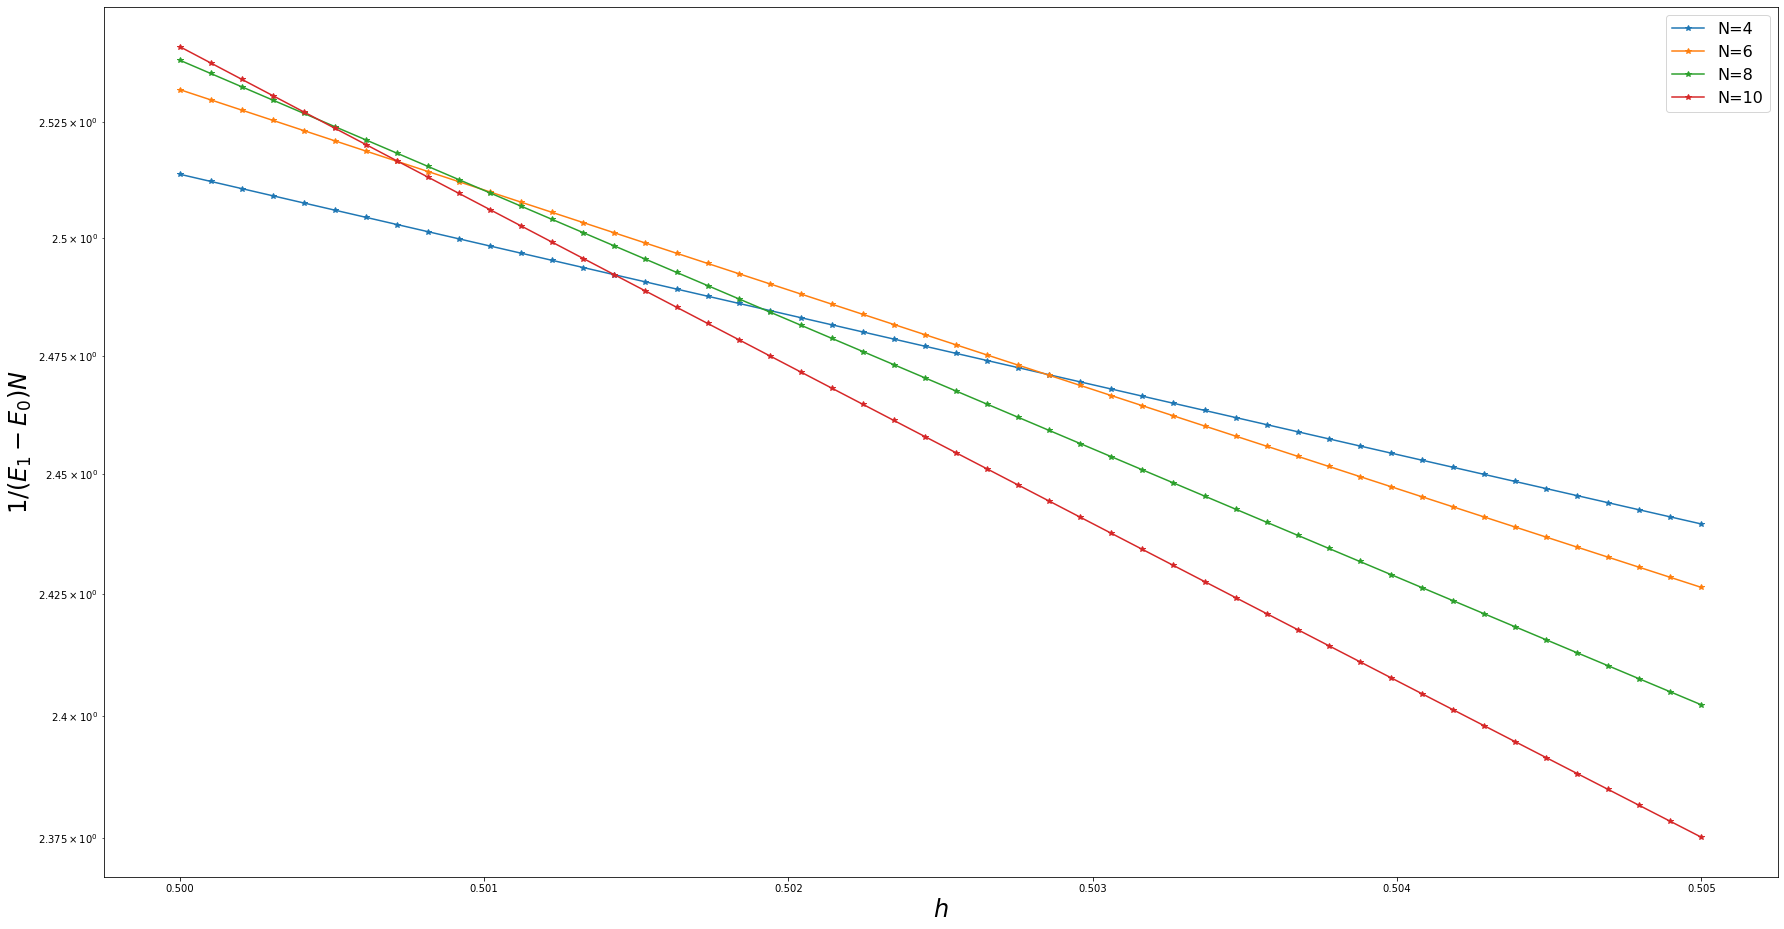

In [10]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(10*3,8*2))


for N in [4,6,8,10]:
    print(N)
    h = np.linspace(0.5,0.505)
    E0 = np.zeros_like(h)
    E1 = np.zeros_like(h)      
    mx = np.zeros_like(h)
    mz = np.zeros_like(h)

    for i in range(h.shape[0]):
        H = -J*H_XX(N)-h[i]*H_Z(N)
        # w, v = np.linalg.eigh(H)
        w, v = eigsh(H, 2, which='SA')
        # print(v.shape)
        E0[i] = w[0]
        E1[i] = w[1]
        mx[i] = v[:,1]@H_X(N)@v[:,0]/N
        mz[i] = v[:,0]@H_Z(N)@v[:,0]/N

    # xi/L
    ax.plot(h, 1/((E1-E0)*N), '*-', label='N={}'.format(N))
    ax.legend(fontsize=16)
    ax.set_xlabel(r'$h$',fontsize=24)
    ax.set_ylabel(r'$1/(E_1-E_0)N$',fontsize=24)
    ax.semilogy()
    ax.grid()    
    

In [4]:
def Ek(J, h, k):
    return np.sqrt((J/2)**2+h**2+J*h*np.cos(k))

[0.36840644 0.69948316 0.69948316 0.36840644]
[0.55901699 0.75       0.55901699 0.25      ]
[-1.06788960e+00 -1.05901699e+00 -3.31076723e-01 -2.50000000e-01
 -2.50000000e-01 -5.90169944e-02 -2.06089200e-17  1.65804365e-17
  1.07318771e-16  1.43214228e-16  5.90169944e-02  2.50000000e-01
  2.50000000e-01  3.31076723e-01  1.05901699e+00  1.06788960e+00]
-1.0678896025349285
-1.0590169943749475


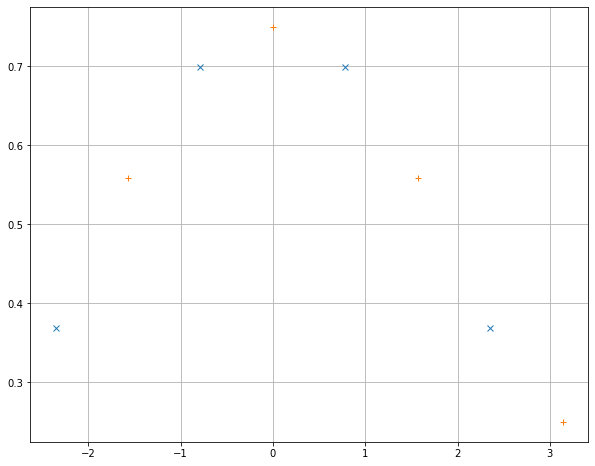

In [18]:
J = 1
h = 1/4

N = 4

k_a = np.arange(-(N-1), N, 2)*np.pi/N
k_p = np.arange(-(N-2), N+1, 2)*np.pi/N
# print(k_a)
# print(k_p)
Ek_a = Ek(J, h, k_a)
Ek_p = Ek(J, h, k_p)

print(Ek_a)
print(Ek_p)

E0 = -np.sum(Ek_a)/2
E1 = -(np.sum(Ek_p[0:N//2-1])+np.sum(Ek_p[N//2:-1]))/2 - J/2

H = -J*H_ZZ(N)-h*H_X(N)
w, v = np.linalg.eigh(H)
print(w)

print(E0)
print(E1)

fig, ax = plt.subplots(figsize=(10,8))
ax.plot(k_a, Ek_a, 'x')
ax.plot(k_p, Ek_p, '+')
ax.grid()